In [121]:
import torch
import torch.nn.functional as F
import os

os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


def get_contrast_image(img: torch.Tensor, kernel_size: int = 8, sigma: float = 0.5) -> torch.Tensor:
    B, C, H, W = img.shape
    coords = torch.arange(kernel_size, dtype=img.dtype, device=img.device) - kernel_size // 2
    g = torch.exp(-(coords**2) / (2 * sigma**2))
    g = g / g.sum()

    g2d = torch.outer(g, g)
    g2d = g2d.expand(C, 1, kernel_size, kernel_size)

    local_mean = F.conv2d(img, g2d, padding=kernel_size // 2, groups=C)
    img_squared = img * img
    local_mean_sq = F.conv2d(img_squared, g2d, padding=kernel_size // 2, groups=C)

    contrast = torch.sqrt((local_mean_sq - local_mean ** 2).clamp(min=1e-10))
    return contrast


def show_tensor_images(tensor: torch.Tensor, num_images: int=5, title: str="", figsize: tuple=(12, 6)):
    import matplotlib.pyplot as plt
    tensor = tensor.detach().cpu()
    if tensor.ndim == 3:
        tensor = tensor.unsqueeze(0)
    assert tensor.ndim == 4, f"Expected 3D or 4D tensor, got shape {tensor.shape}"

    batch_size = tensor.size(0)
    num_images = min(num_images, batch_size)

    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title, fontsize=16)

    for i in range(num_images):
        img = tensor[i]
        img = torch.clamp(img, 0, 1)
        img_np = img.permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

cuda


Loaded 181 HDR images
Batch keys: dict_keys(['scale', 'y_ulaw', 'y_rgb', 'filename'])
Scale shape: torch.Size([2])
y_ulaw shape: torch.Size([2, 3, 256, 256])
y_rgb shape: torch.Size([2, 3, 256, 256])
Filenames: ['049.exr', '107.exr']


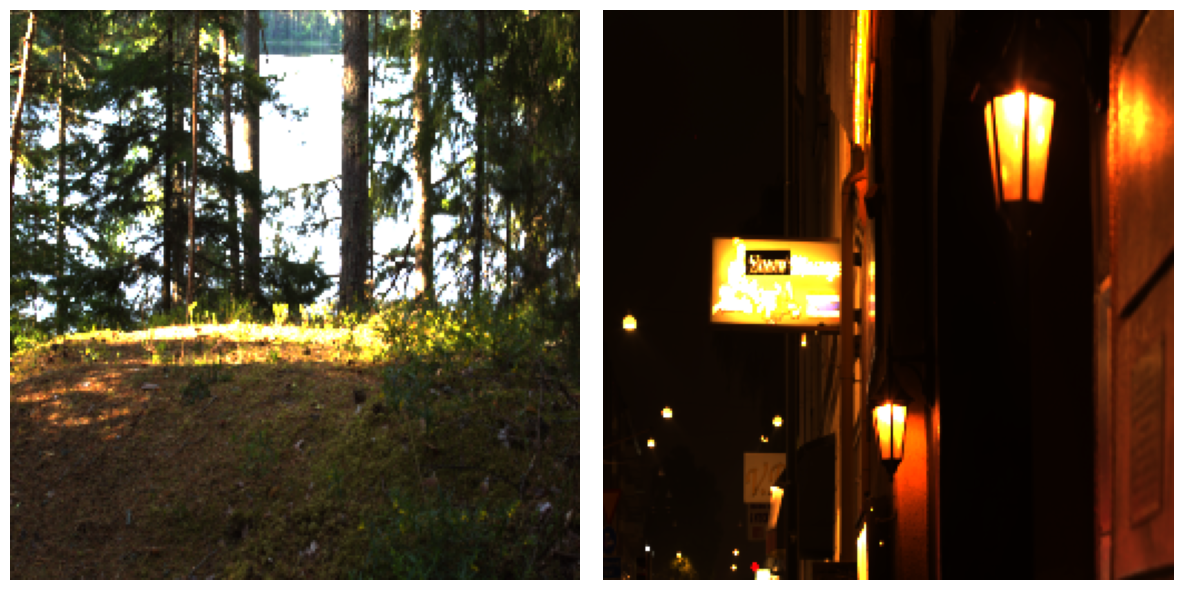

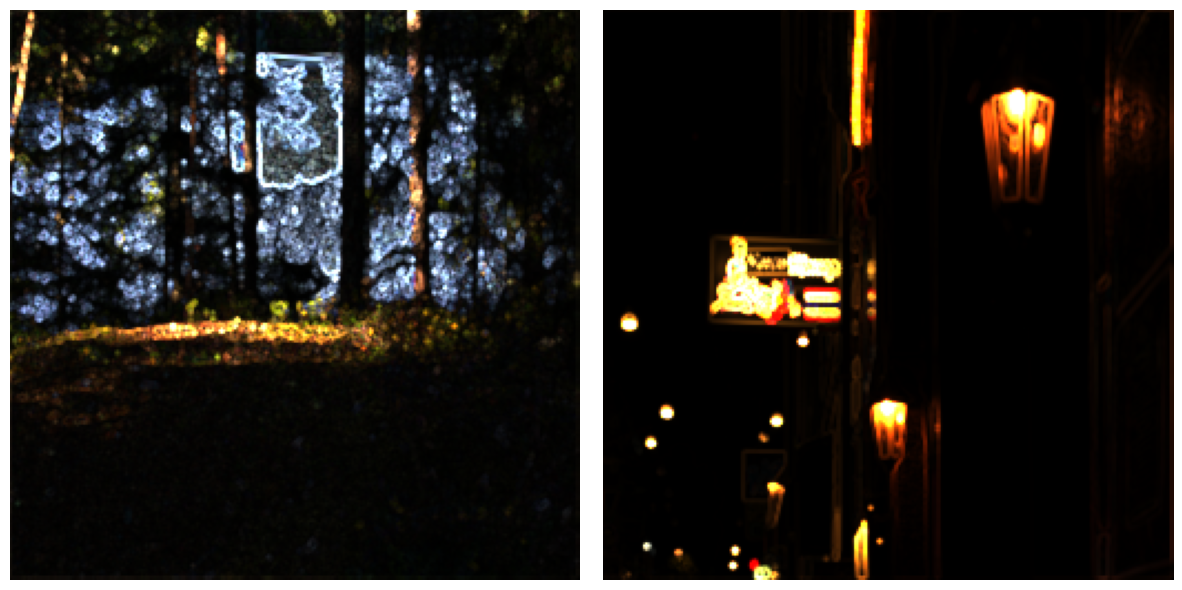

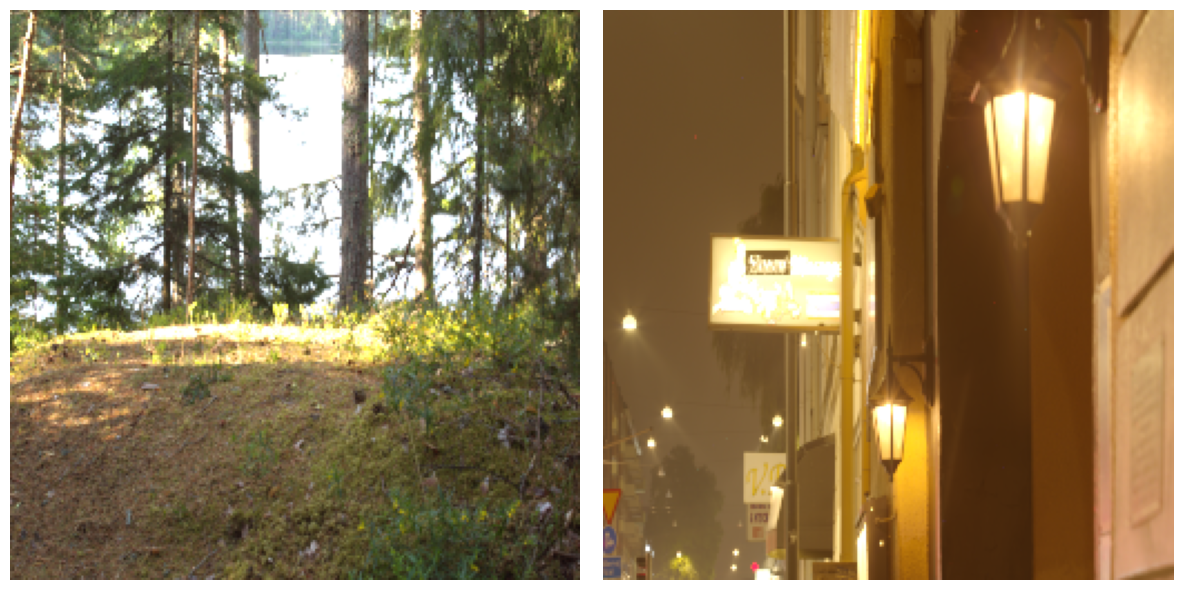

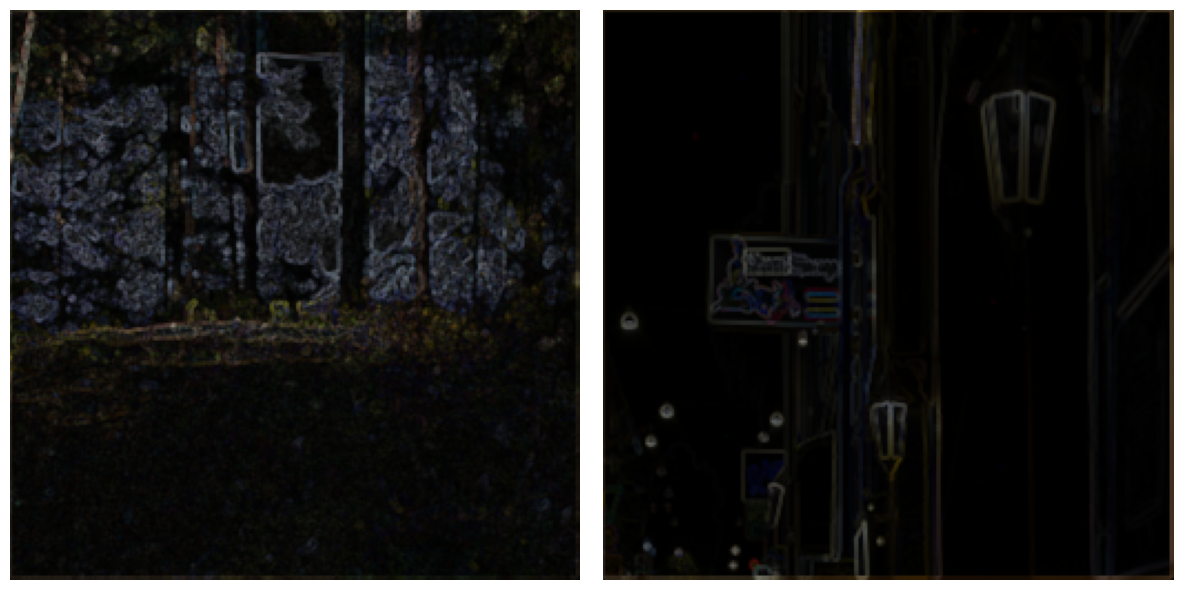

In [122]:
import os

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"

class IOException(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


def writeLDR(img, file):
    try:
        img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
        cv2.imwrite(file, img * 255.0)
    except Exception as e:
        raise IOException("Failed writing LDR image: %s" % e)


def norm(x):
    x_max = np.max(x)
    x_min = np.min(x)
    scale = x_max - x_min
    x_norm = (x - x_min) / scale
    return x_norm


def norm_mean(img):
    img = 0.5 * img / img.mean()
    return img


def ulaw_np(img, scale=10.0):
    median_value = np.median(img)
    scale = 8.759 * np.power(median_value, 2.148) + 0.1494 * np.power(
        median_value, -2.067
    )
    out = np.log(1 + scale * img) / np.log(1 + scale)
    return out, scale


def load_hdr_ldr_norm_ulaw(name_hdr):
    y = cv2.imread(name_hdr, flags=cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
    y_rgb = np.maximum(cv2.cvtColor(y, cv2.COLOR_BGR2RGB), 0.0)
    y_rgb = norm_mean(y_rgb)
    y_ulaw, scale = ulaw_np(y_rgb)
    return scale, y_ulaw, y_rgb


class HDRDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (str): Ścieżka do katalogu z plikami HDR.
            transform (callable, optional): Opcjonalna transformacja do zastosowania na danych.
        """
        self.directory = directory
        self.transform = transform

        self.hdr_files = [f for f in os.listdir(directory) if f.endswith(".exr")]
        if not self.hdr_files:
            raise ValueError(f"No HDR files found in directory: {directory}")

    def __len__(self):
        """Zwraca liczbę próbek w datasetcie."""
        return len(self.hdr_files)

    def __getitem__(self, idx):
        """Zwraca próbkę o podanym indeksie."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        hdr_path = os.path.join(self.directory, self.hdr_files[idx])

        scale, y_ulaw, y_rgb = load_hdr_ldr_norm_ulaw(hdr_path)

        y_ulaw = torch.from_numpy(y_ulaw).float()
        y_rgb = torch.from_numpy(y_rgb).float()
        scale = torch.tensor(scale).float()

        y_ulaw = y_ulaw.permute(2, 0, 1)
        y_rgb = y_rgb.permute(2, 0, 1)

        if self.transform:
            y_ulaw = self.transform(y_ulaw)
            y_rgb = self.transform(y_rgb)

        sample = {
            "scale": scale,
            "y_ulaw": y_ulaw,
            "y_rgb": y_rgb,
            "filename": self.hdr_files[idx],
        }
        return sample

data_dir = "data_resized"

dataset = HDRDataset(directory=data_dir)
print(f"Loaded {len(dataset)} HDR images")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

for batch in dataloader:
    print("Batch keys:", batch.keys())
    print("Scale shape:", batch["scale"].shape)
    print("y_ulaw shape:", batch["y_ulaw"].shape)
    print("y_rgb shape:", batch["y_rgb"].shape)
    print("Filenames:", batch["filename"])
    show_tensor_images(batch["y_rgb"])
    show_tensor_images(get_contrast_image(batch["y_rgb"]))
    show_tensor_images(batch["y_ulaw"])
    show_tensor_images(get_contrast_image(batch["y_ulaw"]))
    break


Loaded 181 HDR images


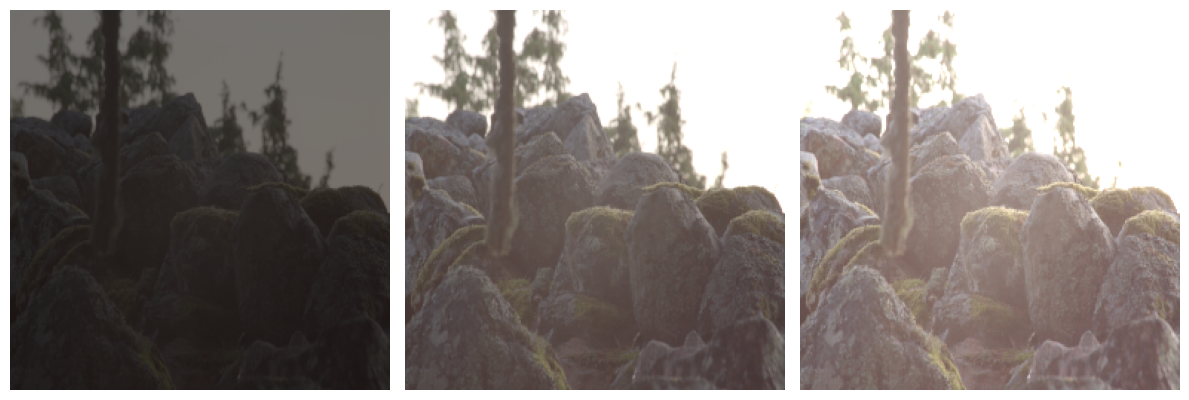

In [123]:
import torch

def mul_exp(img):
    x_p = 1.21497
    c_start = torch.log((x_p / torch.max(img)) / torch.log(torch.tensor(2.0, device=img.device)))
    c_end = torch.log((x_p / torch.quantile(img, 0.5)) / torch.log(torch.tensor(2.0, device=img.device)))

    output_list = []
    exp_value = [c_start, (c_end + c_start) / 2.0, c_end]

    for i in range(len(exp_value)):
        sc = torch.pow(torch.sqrt(torch.tensor(2.0, device=img.device)), exp_value[i])
        img_exp = img * sc
        img_pow = img_exp
        img_out = torch.where(img_pow > 1.0, torch.ones_like(img_pow), img_pow)
        output_list.append(img_out)

    return output_list


def mul_direct_scale(img, scales=[0.4, 1.0, 1.5]):
    output_list = []
    for scale in scales:
        img_scaled = img * scale
        img_out = torch.clamp(img_scaled, 0.0, 1.0)
        output_list.append(img_out)
    return output_list


dataset = HDRDataset(directory=data_dir)
print(f"Loaded {len(dataset)} HDR images")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for batch in dataloader:
    output_list = mul_direct_scale(batch["y_ulaw"])
    transformed_output = torch.stack(output_list, dim=0)
    A, B, C, H, W = transformed_output.shape
    transformed_output = transformed_output.view(A*B, C, H, W)
    show_tensor_images(transformed_output)
    break

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

torch.manual_seed(42)

class VGGFeatureExtractor(nn.Module):
    def __init__(self, layer_names, vgg_version='vgg19', pretrained=True):
        super(VGGFeatureExtractor, self).__init__()
        self.layer_names = layer_names

        if vgg_version == 'vgg19':
            vgg = models.vgg19(pretrained=pretrained).features
        elif vgg_version == 'vgg16':
            vgg = models.vgg16(pretrained=pretrained).features
        else:
            raise ValueError(f"Unsupported VGG version: {vgg_version}")

        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.hooks = {}
        self.outputs = {}

        for name in self.layer_names:
            layer = dict(self.vgg._modules)[name]
            layer.register_forward_hook(self._make_hook(name))

    def _make_hook(self, name):
        def hook(module, input, output):
            self.outputs[name] = output
        return hook

    def forward(self, x):
        _ = self.vgg(x)
        return {name: self.outputs[name] for name in self.layer_names}


class ContrastivePerceptualLoss(nn.Module):
    def __init__(self, layer_names, layer_weights, vgg_version='vgg19', kernel_size=4, sigma=0.5):
        if len(layer_names) != len(layer_weights):
            raise ValueError(f"For layer_weights expected {len(layer_names)} values, got {len(layer_weights)} instead")
        super().__init__()
        self.feature_extractor = VGGFeatureExtractor(layer_names, vgg_version=vgg_version)
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.criterion = nn.L1Loss()
        self.layer_weights = layer_weights

    def forward(self, input_img, target_img):
        input_feats = self.feature_extractor(input_img)
        target_feats = self.feature_extractor(target_img)

        loss = 0.0
        for i, layer in enumerate(input_feats):
            contrast_input = get_contrast_image(input_feats[layer])
            contrast_target = get_contrast_image(target_feats[layer])
            loss += self.layer_weights[i] * self.criterion(contrast_input, contrast_target)

        return loss


loss_fn = ContrastivePerceptualLoss(layer_names=['0', '5', '10'], layer_weights=[1.0, 0.8, 0.7])
dataset = HDRDataset(directory=data_dir)
print(f"Loaded {len(dataset)} HDR images")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
for batch in dataloader:
    print("CPLoss:", loss_fn(batch["y_rgb"], batch["y_ulaw"]))
    break

Loaded 181 HDR images
CPLoss: tensor(2.0702)


In [125]:
import torch
import torch.nn as nn
torch.manual_seed(42)


class Encoder(nn.Module):
    def __init__(self, input_channels):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding="same",
        )

        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding="same"
        )

        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        out_1 = self.conv1(x)
        out_1_relu = self.relu(out_1)

        out_2 = self.conv2(out_1_relu)
        out_2_relu = self.relu(out_2)

        out_3 = self.conv3(out_2_relu)
        out_3_relu = self.relu(out_3)

        return out_3_relu


input_channels = 3
encoder = Encoder(input_channels)
input_tensor = torch.randn(1, input_channels, 256, 256)
output = encoder(input_tensor)
print(output.shape)


torch.Size([1, 64, 256, 256])


In [126]:
import torch
import torch.nn as nn
torch.manual_seed(42)


class Decoder(nn.Module):
    def __init__(self, input_channels):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding="same"
        )

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding="same"
        )

        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=3,
            kernel_size=3,
            stride=1,
            padding="same"
        )

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, img_1, img_2, img_3):
        out_1 = self.conv1(input)
        out_1_relu = self.relu(out_1)

        out_2 = self.conv2(out_1_relu)
        out_2_relu = self.relu(out_2)

        out_3 = self.conv3(out_2_relu)

        out = out_3 + img_1 + img_2 + img_3
        out = self.sigmoid(out)

        return out, out_3

height = 256
width = 256
input_channels = 64
decoder = Decoder(input_channels=input_channels)
input_tensor = torch.randn(1, input_channels, height, width)
img_1 = torch.randn(1, 3, height, width)
img_2 = torch.randn(1, 3, height, width)
img_3 = torch.randn(1, 3, height, width)
output, out_3 = decoder(input_tensor, img_1, img_2, img_3)

print(output.shape)
print(out_3.shape)


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [127]:
import torch
import torch.nn as nn
torch.manual_seed(42)


class TMONet(nn.Module):
    def __init__(self, input_channels=3):
        super(TMONet, self).__init__()
        self.encoder = Encoder(input_channels=input_channels)
        self.conv_gated_1 = nn.Conv2d(
            in_channels=64 * 3,
            out_channels=64 * 3,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv_gated_2 = nn.Conv2d(
            in_channels=64 * 3,
            out_channels=64 * 3,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.decoder = Decoder(input_channels=64 * 3)

    def forward(self, input_1, input_2, input_3):
        output_1 = self.encoder(input_1)
        output_2 = self.encoder(input_2)
        output_3 = self.encoder(input_3)
        out_concat = torch.cat([output_1, output_2, output_3], dim=1)
        out_gated_1 = self.conv_gated_1(out_concat)
        out_gated_2 = self.conv_gated_2(out_gated_1)
        out_img, out_res = self.decoder(out_gated_2, input_1, input_2, input_3)

        return out_img

tmo_net = TMONet(input_channels=3)
height = 256
width = 256
input_1 = torch.randn(1, 3, height, width)
input_2 = torch.randn(1, 3, height, width)
input_3 = torch.randn(1, 3, height, width)
output = tmo_net(input_1, input_2, input_3)
print(output.shape)


torch.Size([1, 3, 256, 256])


In [128]:
import os

import numpy as np
import torch
from brisque import BRISQUE
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, random_split
from torchvision.utils import save_image
from tqdm.notebook import tqdm
torch.manual_seed(42)


def lum(img):
    return 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]


def evaluate_image(image) -> float:
    metric = BRISQUE(url=False)
    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = (image * 255).clip(0, 255).astype(np.uint8)
    return metric.score(img=image)


def reinhard_tone_mapping(hdr_image):
    luminance = lum(hdr_image)
    log_avg_lum = np.exp(np.mean(np.log(luminance + 1e-8)))
    scaled_lum = (luminance * (1.0 / log_avg_lum)) / (
        1.0 + luminance * (1.0 / log_avg_lum)
    )
    tone_mapped = np.zeros_like(hdr_image)
    for c in range(3):
        tone_mapped[:, :, c] = (hdr_image[:, :, c] / (luminance + 1e-8)) * scaled_lum
    return np.clip(tone_mapped, 0, 1)


config = {
    "epochs": 10,
    "batch_size": 1,
    "learning_rate": 1e-3,
    "data_dir": "data_resized",
    "validation_split": 0.2,
    "valid_step": 1,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "output_dir": "output_images",
}


def train(config: dict) -> None:
    print(config)
    device = torch.device(config["device"])

    base_dataset = HDRDataset(directory=config["data_dir"])
    train_size = int((1 - config["validation_split"]) * len(base_dataset))
    val_size = len(base_dataset) - train_size
    train_dataset, val_dataset = random_split(base_dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = TMONet(input_channels=3).to(device)
    criterion = ContrastivePerceptualLoss(layer_names=['0', '5', '10', '19'], layer_weights=[1.0, 0.8, 0.7, 0.5]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    os.makedirs(config["output_dir"], exist_ok=True)
    reference_dir = os.path.join(config["output_dir"], "reference")
    os.makedirs(reference_dir, exist_ok=True)

    total_batches = len(train_loader) + (
        len(val_loader) if config["valid_step"] > 0 else 0
    )

    with torch.no_grad():
        brisque_total = 0.0
        num_samples = 0
        for batch_idx, batch in enumerate(
            tqdm(val_loader, desc="Processing Validation Data", unit="batch")
        ):
            hdr_rgb = batch["y_rgb"].float().to(device)

            for i in range(hdr_rgb.size(0)):
                hdr_np = hdr_rgb[i].cpu().numpy().transpose(1, 2, 0)  # (H, W, C)

                tone_mapped_np = reinhard_tone_mapping(hdr_np)

                tone_mapped_tensor = torch.from_numpy(
                    tone_mapped_np.transpose(2, 0, 1)
                ).float()

                img_filename = os.path.join(
                    reference_dir, f"val_{batch_idx * config['batch_size'] + i}.png"
                )
                save_image(tone_mapped_tensor, img_filename)

                brisque_score = evaluate_image(tone_mapped_tensor)
                brisque_total += brisque_score
                num_samples += 1

    reinhard_brisque_score = brisque_total / num_samples if num_samples > 0 else 0.0

    for epoch in range(1, config["epochs"] + 1):
        progress_bar = tqdm(
            total=total_batches, desc=f"Epoch {epoch}/{config['epochs']}", unit="batch"
        )

        model.train()
        for step, batch in enumerate(train_loader):
            hdr_ulaw = batch["y_ulaw"].float().to(device)
            hdr_rgb = batch["y_rgb"].float().to(device)

            optimizer.zero_grad()
            output_list = mul_direct_scale(hdr_ulaw)
            output = model(output_list[0], output_list[1], output_list[2])

            loss = criterion(output, hdr_rgb)
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(stage="Training", loss=loss.item())
            progress_bar.update(1)

        if epoch % config["valid_step"] == 0:
            os.makedirs(os.path.join(config["output_dir"], f"{epoch}"), exist_ok=True)
            model.eval()
            val_loss_total = 0.0
            val_brisque_total = 0.0
            num_samples = 0

            with torch.no_grad():
                for batch_idx, batch in enumerate(val_loader):
                    hdr_ulaw = batch["y_ulaw"].float().to(device)
                    hdr_rgb = batch["y_rgb"].float().to(device)

                    output_list = mul_direct_scale(hdr_ulaw)
                    output = model(output_list[0], output_list[1], output_list[2])

                    val_loss = criterion(output, hdr_rgb)
                    val_loss_total += val_loss.item() * output.size(0)

                    for i in range(output.size(0)):
                        xx = hdr_ulaw[i].cpu().numpy().transpose(1, 2, 0)
                        yy = hdr_rgb[i].cpu().numpy().transpose(1, 2, 0)
                        y_pred = output[i].cpu().numpy().transpose(1, 2, 0)
                        a = 0.6
                        r = yy[:, :, 0]
                        g = yy[:, :, 1]
                        b = yy[:, :, 2]
                        y_gt_lum_np = lum(yy)
                        yy_predict_np_lum = lum(y_pred)
                        img_out = np.zeros(np.shape(yy))
                        img_out[:, :, 0] = (
                            r / (y_gt_lum_np + 1e-8)
                        ) ** a * yy_predict_np_lum
                        img_out[:, :, 1] = (
                            g / (y_gt_lum_np + 1e-8)
                        ) ** a * yy_predict_np_lum
                        img_out[:, :, 2] = (
                            b / (y_gt_lum_np + 1e-8)
                        ) ** a * yy_predict_np_lum
                        img_out = np.clip(
                            img_out, 0, 1
                        )
                        img_tensor = torch.from_numpy(
                            img_out.transpose(2, 0, 1)
                        ).float()
                        brisque_score = evaluate_image(img_tensor)
                        val_brisque_total += brisque_score
                        img_filename = os.path.join(
                            config["output_dir"],
                            f"{epoch}/{batch_idx * config['batch_size'] + i}.png",
                        )
                        save_image(img_tensor, img_filename)

                    num_samples += output.size(0)
                    progress_bar.set_postfix(stage="Validation")
                    progress_bar.update(1)

            avg_val_loss = val_loss_total / num_samples
            avg_brisque_score = val_brisque_total / num_samples

            progress_bar.set_postfix(
                stage="Validation",
                val_loss=avg_val_loss,
                val_brisque=avg_brisque_score,
                reinhard_brisque_score=reinhard_brisque_score,
            )
            print(
                f"Epoch {epoch}/{config['epochs']} - Avg Val Loss: {avg_val_loss:.4f}, Avg BRISQUE: {avg_brisque_score:.4f}, Avg BRISQUE Reinhard: {reinhard_brisque_score:.4f}"
            )

        progress_bar.close()


train(config)


{'epochs': 10, 'batch_size': 1, 'learning_rate': 0.001, 'data_dir': 'data_resized', 'validation_split': 0.2, 'valid_step': 1, 'device': 'cuda', 'output_dir': 'output_images'}


Processing Validation Data:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 1/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 1/10 - Avg Val Loss: 5.6891, Avg BRISQUE: 45.2308, Avg BRISQUE Reinhard: 22.3891


Epoch 2/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 2/10 - Avg Val Loss: 5.5692, Avg BRISQUE: 34.1352, Avg BRISQUE Reinhard: 22.3891


Epoch 3/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 3/10 - Avg Val Loss: 5.5922, Avg BRISQUE: 38.5142, Avg BRISQUE Reinhard: 22.3891


Epoch 4/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 4/10 - Avg Val Loss: 5.5315, Avg BRISQUE: 21.8684, Avg BRISQUE Reinhard: 22.3891


Epoch 5/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 5/10 - Avg Val Loss: 5.5159, Avg BRISQUE: 25.3483, Avg BRISQUE Reinhard: 22.3891


Epoch 6/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 6/10 - Avg Val Loss: 5.6039, Avg BRISQUE: 21.3115, Avg BRISQUE Reinhard: 22.3891


Epoch 7/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 7/10 - Avg Val Loss: 5.5167, Avg BRISQUE: 27.1817, Avg BRISQUE Reinhard: 22.3891


Epoch 8/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 8/10 - Avg Val Loss: 5.5334, Avg BRISQUE: 29.3553, Avg BRISQUE Reinhard: 22.3891


Epoch 9/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 9/10 - Avg Val Loss: 5.5122, Avg BRISQUE: 28.8622, Avg BRISQUE Reinhard: 22.3891


Epoch 10/10:   0%|          | 0/181 [00:00<?, ?batch/s]

Epoch 10/10 - Avg Val Loss: 5.5275, Avg BRISQUE: 31.9145, Avg BRISQUE Reinhard: 22.3891
